In [0]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder  # For categorical data
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [0]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
import pydot
import seaborn as sns
import itertools
#from pandas_ml import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('Global_Landslide_Final.csv')
df.shape # See how many data objects & attributes we have
df.head(5) # View first 5 data objects
df.landslide_trigger.unique() #See how many unique triggers we have

array(['Construction', 'Earthquake', 'Flooding', 'Mining', 'Monsoon',
       'Rain', 'Snow', 'Tropical_Cyclone'], dtype=object)

In [0]:
# data preprocessing by removing noise, replacing NaN
# values, replacing NaN/empty values with the median of that attribute and dropping
# columns that wouldn't help our model train
# Remove unwanted columns
df = df.drop(columns=['formatted_date','event_date','event_day','event_title',
                      'event_id','event_description','location_description',
                      'location_accuracy','gazeteer_closest_point', 'country_code','gazeteer_distance'])
df = df.dropna(subset=['landslide_trigger'])

In [8]:
# Replace NaN values in fatality & injury count with the medians
df['fatality_count'].fillna((df['fatality_count'].median()), inplace=True)
df['injury_count'].fillna((df['injury_count'].median()), inplace=True)
df['population'].fillna((df['population'].median()), inplace=True)
df.isnull().sum() # check for missing values in dataset

landslide_trigger        0
event_month              0
event_time             397
landslide_category       0
landslide_size           0
fatality_count           0
injury_count             0
country_name          1160
population               0
longitude                0
latitude                 0
dtype: int64

In [0]:
# Delete attribute values that we don't want to classify:
df = df[df.landslide_size != "catastrophic"]
df = df[df.landslide_category != "unknown"]
df = df[df.landslide_category != "other"]
df = df[df.country_name != "NaN"]

In [0]:
# Update trigger values so reduce unnessessary unique values
df['event_time'] = df['event_time'].replace('unknown', 'NaN')

In [11]:
# Update landlside size values so reduce unnessessary unique values
df['landslide_size'] = df['landslide_size'].replace('very_large', 'large')
print('Landslide triggers:', df.landslide_trigger.unique())

Landslide triggers: ['Construction' 'Earthquake' 'Flooding' 'Mining' 'Monsoon' 'Rain' 'Snow'
 'Tropical_Cyclone']


Rain                7964
Tropical_Cyclone     562
Snow                 133
Monsoon              129
Mining                93
Earthquake            89
Construction          86
Flooding              74
Name: landslide_trigger, dtype: int64

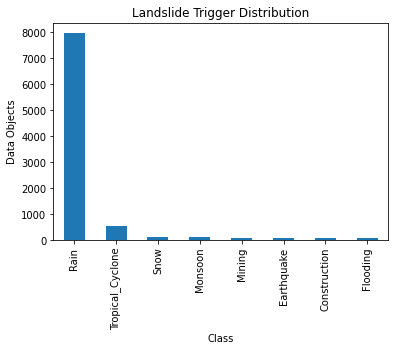

In [12]:
pd.value_counts(df['landslide_trigger']).plot.bar()
plt.title('Landslide Trigger Distribution')
plt.xlabel('Class')
plt.ylabel('Data Objects')
df['landslide_trigger'].value_counts()

In [0]:
df['event_time'] = df['event_time'].astype(str)
df['landslide_category'] = df['landslide_category'].astype(str) 
df['country_name'] = df['country_name'].astype(str) #make sure all country name values are strings

In [0]:
df = pd.get_dummies(df, prefix=['event_time','country_name','landslide_category','landslide_size'], 
                    columns=['event_time','country_name','landslide_category','landslide_size'])

In [15]:
# Label Encode our trigger values into numbers
df["landslide_trigger"] = df["landslide_trigger"].astype('category')
df["landslide_trigger"] = df["landslide_trigger"].cat.codes
df.head(5)

,landslide_trigger,event_month,fatality_count,injury_count,population,longitude,latitude,event_time_0:00,event_time_0:30,event_time_10:00,event_time_10:30,event_time_11:00,event_time_11:30,event_time_12:00,event_time_12:30,event_time_13:00,event_time_13:30,event_time_14:00,event_time_14:30,event_time_15:00,event_time_15:30,event_time_16:00,event_time_16:30,event_time_17:00,event_time_17:30,event_time_18:00,event_time_18:30,event_time_19:00,event_time_19:30,event_time_1:00,event_time_1:30,event_time_20:00,event_time_20:30,event_time_21:00,event_time_21:30,event_time_22:00,event_time_22:30,event_time_23:00,event_time_23:30,event_time_2:00,...,country_name_Slovakia,country_name_Slovenia,country_name_Solomon Islands,country_name_South Africa,country_name_South Korea,country_name_Spain,country_name_Sri Lanka,country_name_Sudan,country_name_Swaziland,country_name_Switzerland,country_name_Taiwan,country_name_Tajikistan,country_name_Tanzania,country_name_Thailand,country_name_Trinidad and Tobago,country_name_Turkey,country_name_U.S. Virgin Islands,country_name_Uganda,country_name_Ukraine,country_name_United Arab Emirates,country_name_United Kingdom,country_name_United States,country_name_Vanuatu,country_name_Venezuela,country_name_Vietnam,country_name_Yemen,country_name_nan,landslide_category_complex,landslide_category_creep,landslide_category_debris_flow,landslide_category_earth_fall,landslide_category_earth_flow,landslide_category_lahar,landslide_category_rock_fall,landslide_category_slide,landslide_category_snow_avalanche,landslide_size_large,landslide_size_medium,landslide_size_small,landslide_size_unknown
0,0,7,0.0,0.0,11886.0,145.1147,-37.8558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,8,0.0,0.0,112050.0,92.7490,11.6753,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,9,0.0,0.0,193750.0,28.7701,41.0863,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,8,2.0,4.0,601600.0,73.0399,33.6941,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,5,8.0,0.0,2628.0,44.5015,42.7204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [0]:
Y = np.array(df['landslide_trigger']) 
df = df.drop('landslide_trigger',axis=1)

In [0]:
# Save the column headers 
feature_list = list(df.columns)
#X = df.as_matrix() # Holds our data objects and attributes
X = df.values

In [20]:
# Splitting dataset into training and test set
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size =.20)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print("Before OverSampling, counts of label '0': {}".format(sum(train_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(train_labels==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(train_labels==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(train_labels==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(train_labels==4)))
print("Before OverSampling, counts of label '5': {}".format(sum(train_labels==5)))
print("Before OverSampling, counts of label '6': {}".format(sum(train_labels==6)))
print("Before OverSampling, counts of label '7': {}".format(sum(train_labels==7)))

Training Features Shape: (7304, 180)
Training Labels Shape: (7304,)
Testing Features Shape: (1826, 180)
Testing Labels Shape: (1826,)
Before OverSampling, counts of label '0': 69
Before OverSampling, counts of label '1': 76
Before OverSampling, counts of label '2': 62
Before OverSampling, counts of label '3': 73
Before OverSampling, counts of label '4': 112
Before OverSampling, counts of label '5': 6352
Before OverSampling, counts of label '6': 99
Before OverSampling, counts of label '7': 461


In [0]:
sm = ADASYN(sampling_strategy='auto')
train_features_res, train_labels_res = sm.fit_sample(train_features, train_labels.ravel())
sm_svm = SMOTE(kind='svm',sampling_strategy='all')
X_smote, Y_smote = sm.fit_sample(train_features, train_labels)

In [22]:
print('After OverSampling, the shape of train_features: {}'.format(train_features_res.shape))
print('After OverSampling, the shape of train_labels: {} \n'.format(train_labels_res.shape))
print("After OverSampling, counts of label '0': {}".format(sum(train_labels_res==0)))
print("After OverSampling, counts of label '1': {}".format(sum(train_labels_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(train_labels_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(train_labels_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(train_labels_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(train_labels_res==5)))
print("After OverSampling, counts of label '6': {}".format(sum(train_labels_res==6)))
print("After OverSampling, counts of label '7': {}".format(sum(train_labels_res==7)))

After OverSampling, the shape of train_features: (50860, 180)
After OverSampling, the shape of train_labels: (50860,) 

After OverSampling, counts of label '0': 6331
After OverSampling, counts of label '1': 6336
After OverSampling, counts of label '2': 6358
After OverSampling, counts of label '3': 6381
After OverSampling, counts of label '4': 6341
After OverSampling, counts of label '5': 6352
After OverSampling, counts of label '6': 6377
After OverSampling, counts of label '7': 6384


In [0]:
# GridSearchCV to find the best hyperparameters for our models.

tuned_parameters = [{'n_estimators': [100, 200, 500, 1000, 1500], 
                     'max_features': ['auto', 'sqrt', 'log2'],
                     'min_samples_leaf': [50, 75, 100, 150],
                     'random_state': [0, 50],
                     'class_weight': ['balanced', 
                                    {0:100, 1:100, 2:100, 3:1000, 4:10, 5:1, 6:10, 7:10},
                                    {0:1, 1:1, 2:1, 3:1, 4:1, 5:.01, 6:.1, 7:.1}]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(train_features, train_labels)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_labels, clf.predict(test_features)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100, 'random_state': 0}

Grid scores on development set:

0.377 (+/-0.051) for {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100, 'random_state': 0}
0.333 (+/-0.043) for {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100, 'random_state': 50}
0.371 (+/-0.055) for {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 200, 'random_state': 0}
0.371 (+/-0.057) for {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 200, 'random_state': 50}
0.369 (+/-0.037) for {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 500, 'random_state': 0}
0.374 (+/-0.070) for {'class_weight': 'balanced', 'max_features': 'au

In [0]:
# the model training completed for both our random forest and svm classifiers.

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=1500, random_state=50, min_samples_leaf=75,
                            class_weight='balanced')
# SVM
svclassifier = SVC(kernel='rbf', class_weight='balanced', C=1.0, random_state=0, 
                   decision_function_shape = 'ovo')

rf.fit(train_features_res, train_labels_res.ravel());
svclassifier.fit(X_smote, Y_smote)  
y_pred = svclassifier.predict(test_features) 

In [0]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    recall = 100 * recall_score(test_labels, predictions, average='macro')
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Recall = {:0.2f}%.'.format(recall))
    return accuracy

def model_report(model_predictions):
    triggers = [0,1,2,3,4,5,6,7]
    print(classification_report(test_labels, model_predictions,
                            triggers))
    confusionMatrix = confusion_matrix(test_labels, model_predictions)
    print("Confusion Matrix:\n%s" % confusionMatrix)

In [0]:
rf_accuracy = evaluate(rf, test_features, test_labels)
svm_accuracy = evaluate(svclassifier, test_features, test_labels)
print('Improvement of {:0.2f}%.'.format( 100 * (rf_accuracy - svm_accuracy) / svm_accuracy))

rf_predictions = rf.predict(test_features)
svclassifier_predictions = svclassifier.predict(test_features)

model_report(rf_predictions)
model_report(svclassifier_predictions)   

Model Performance
Average Error: 1.0100 degrees.
Accuracy = nan%.
Recall = 45.95%.
Model Performance
Average Error: 2.7950 degrees.
Accuracy = nan%.
Recall = 18.24%.
Improvement of nan%.
              precision    recall  f1-score   support

           0       0.36      0.20      0.26        20
           1       0.38      0.17      0.23        18
           2       0.40      0.73      0.52        11
           3       0.36      0.20      0.26        20
           4       0.47      0.62      0.53        26
           5       0.77      0.85      0.81       105
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62       200
   macro avg       0.34      0.34      0.33       200
weighted avg       0.59      0.62      0.59       200

Confusion Matrix:
[[ 4  1  3  3  2  7]
 [ 0  3  2  1  7  5]
 [ 0  0  8  0  0  3]
 [ 3  0  3  4  5  5]
 [ 0  2  0  1 16  7]
 [ 4  2  4  2  4 89]]
              pre

best parameters: {'C': 1}
best score:      0.52815 (+/-0.00637)
{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.108790,0.003260,0.008818,0.000177,1,{'C': 1},0.5375,0.5375,0.5375,0.525,0.525,0.525,0.5250,0.525,0.525,0.518987,0.528149,0.006370,1
1,0.111402,0.003849,0.009031,0.000764,2,{'C': 2},0.5250,0.5375,0.5375,0.525,0.525,0.525,0.5250,0.525,0.525,0.518987,0.526899,0.005591,2
2,0.113042,0.004084,0.008790,0.000163,3,{'C': 3},0.5250,0.5375,0.5375,0.525,0.525,0.525,0.5250,0.525,0.525,0.518987,0.526899,0.005591,2
3,0.115336,0.003905,0.008891,0.000185,4,{'C': 4},0.5125,0.5375,0.5375,0.525,0.525,0.525,0.5250,0.525,0.525,0.518987,0.525649,0.007076,4
4,0.116987,0.006489,0.008920,0.000233,5,{'C': 5},0.5125,0.5375,0.5375,0.525,0.525,0.525,0.5250,0.525,0.525,0.518987,0.525649,0.007076,4
5,0.118078,0.005218,0.008927,0.000156,6,{'C': 6},0.5125,0.5375,0.5375,0.525,0.525,0.525,0.5125,0.525,0.525,0.518987,0.524399,0.008109,6
6,0.120061,0.005800,0.008920,0.000226,7,{'C': 7},0.5125,0.5375,0.5375,0.525,0.525,0.525,0.5125,0.525,0.525,0.518987,0.524399,0.008109,6
7,0.121816,0.005059,0.008927,0.000167,8,{'C': 8},0.5125,0.5375,0.5375,0.525,0.525,0.525,0.5125,0.525,0.525,0.518987,0.524399,0.008109,6
8,0.121830,0.005279,0.008974,0.000183,9,{'C': 9},0.5125,0.5375,0.5375,0.525,0.525,0.525,0.5125,0.525,0.525,0.518987,0.524399,0.008109,6


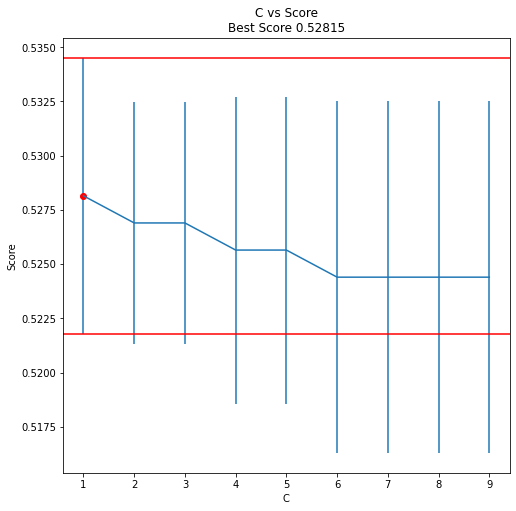

Text(0, 0.5, 'Frequency')

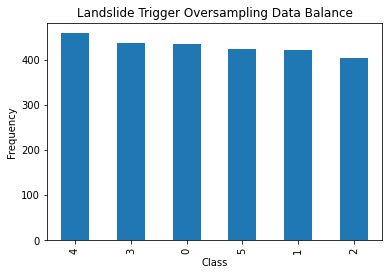

In [0]:
tree = rf.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree_sample.png')

def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

  
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

   
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

grid_clf = GridSearchCV(estimator  = SVC(), 
                        param_grid = {'C': range(1,10)}, 
                        cv         = 10)

_ = grid_clf.fit(train_features, train_labels)

GridSearch_table_plot(grid_clf, "C", negative=False)

unique_elements, counts_elements = np.unique(train_labels_res, return_counts=True)
pd.value_counts(train_labels_res).plot.bar()
plt.title('Landslide Trigger Oversampling Data Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')

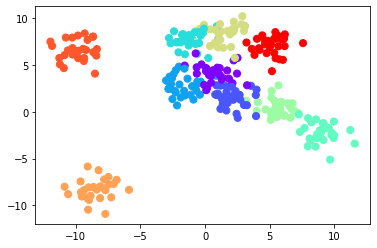

In [0]:
from sklearn.datasets import make_blobs

X, Y = make_blobs(n_samples=300, centers=10,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='rainbow');

ValueError: ignored

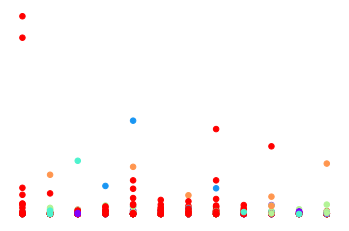

In [0]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

visualize_classifier(rf, train_features, train_labels);

In [0]:
from sklearn.metrics import confusion_matrix
predictions = rf.predict(test_features)
mat = confusion_matrix(test_labels, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train_labels,
            yticklabels=train_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
from sklearn.metrics import classification_report
predictions = rf.predict(test_features)
triggers = [1,2,3,4,5,6,7,8,9,10]
print(classification_report(test_labels, predictions,
                            triggers))